Check where the MHW offset has been applied vs. not. E.g. DH_z is MHW or not? 

In [1]:
import os
import sys
import time
import shutil
import pandas as pd
import numpy as np
import arcpy
import CoastalVarExtractor.functions_warcpy as fwa
import CoastalVarExtractor.functions as fun

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from CoastalVarExtractor.setvars import *

site: Fisherman
year: 2014
setvars.py initialized variables.


In [2]:
# %% Work with pickled dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))

In [3]:
d2i_df = pd.read_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

In [4]:
d2i_df.loc[159]
# transect 14 is 614 m from inlet. Accurate.
# transect 178 is only 87 meters from the inlet, but it calculated 671.
# transect 167 is about 671 m from northern inlet, and it calculated 671.
# The values got stuck... 
# from transects 70-180 the dist2inlet values are all 671.67...

Dist2Inlet    671.673561
Name: 159.0, dtype: float64

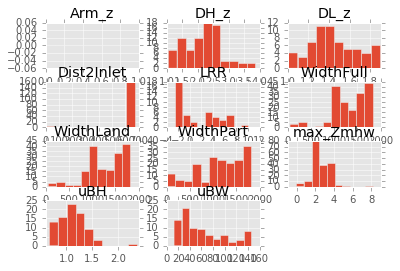

In [13]:
# Histograms for each transect variable
hist_cols = ['Arm_z', 'DH_z', 'DL_z', 'Dist2Inlet', 'LRR', 'WidthFull', 'WidthLand', 
             'WidthPart', 'max_Zmhw', 'uBH', 'uBW']
trans_df.loc[:,hist_cols].hist()
plt.show()
plt.close('all')

In [21]:

pts_set.WidthLand.tail(1) / len(pts_set)

13809    4.98511
Name: WidthLand, dtype: float64

Transect ID (1-180): 68


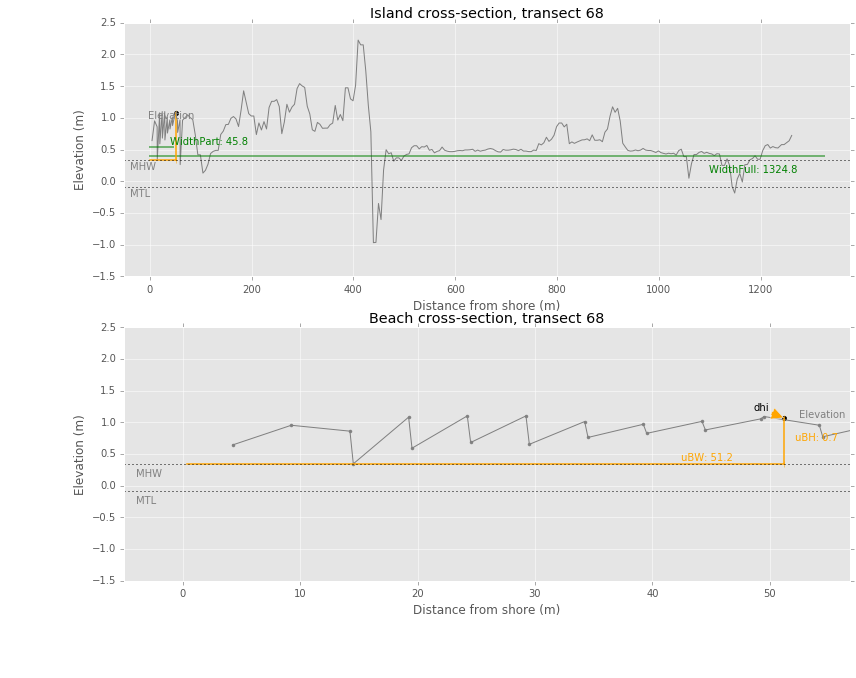

In [15]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]
# plot
fig = plt.figure(figsize=(13,10)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(211)
fun.plot_island_profile(ax, pts_set, MHW, MTL)
ax = fig.add_subplot(212)
fun.plot_beach_profile(ax, pts_set, MHW, MTL)
# display
plt.show()
plt.close('all')

In [22]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Get the transect-averaged values
tran = pts_set.iloc[0]

# Get maximum Z values
idmaxz = pts_set['ptZmhw'].idxmax()
maxz = pts_set['ptZmhw'].loc[idmaxz]
mz_xy = pts_set[['seg_x', 'seg_y']].loc[idmaxz]
mz_dist = np.hypot(mz_xy.seg_x - tran.SL_x, mz_xy.seg_y- tran.SL_y)

# check for presence of values
flds = ['Dist_Seg', 'ptZmhw', 'WidthPart', 'WidthFull']
for fld in flds: 
    if pts_set[fld].isnull().sum():
        print('{}/{} values are missing in column {}.'.format(
            pts_set[fld].isnull().sum(), len(pts_set), fld))


Transect ID (1-180): 68


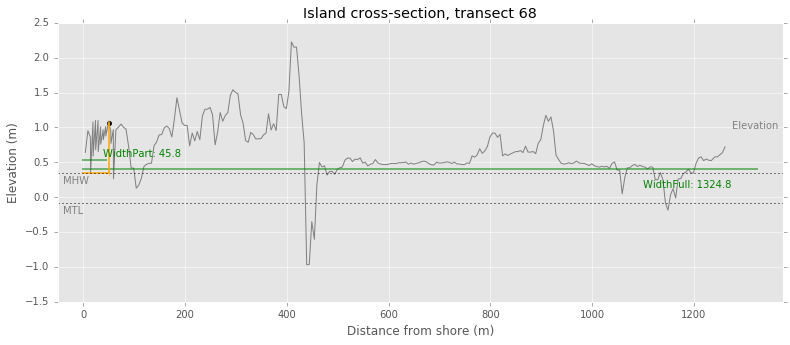

In [23]:
# Full cross-section
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Island cross-section, transect {}'.format(trans_in))

# Plot line
ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, color='gray', linestyle='-', linewidth = 1)
plt.annotate('Elevation', xy=(tran.WidthFull, float(pts_set['ptZmhw'].tail(1))), xytext=(tran.WidthFull-50, float(pts_set['ptZmhw'].tail(1))+0.6), color='gray')

# #Island widths
plt.plot([0, tran.WidthPart],[MHW+0.2, MHW+0.2], color='green', linestyle='-', linewidth = 2, alpha=0.5)
plt.annotate('WidthPart: {:.1f}'.format(tran.WidthPart), xy=(5, MHW+0.2), 
             xytext=(tran.WidthFull*0.03, MHW+0.24), color='green')
plt.plot([0, tran.WidthFull],[MHW+0.06, MHW+0.06], color='green', linestyle='-', linewidth = 2, alpha=0.5)
plt.annotate('WidthFull: {:.1f}'.format(tran.WidthFull), xy=(5, MHW+0.06), 
             xytext=(tran.WidthFull*0.83, MHW-0.2), color='green')

# #Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='black')
plt.scatter(tran.DistDH, tran.DH_z, color='black')
plt.scatter(tran.DistArm, tran.Arm_z, color='black')

# #Upper beach width and height
plt.plot([MHW, tran.uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.plot([tran.uBW, tran.uBW],[MHW, MHW + tran.uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')

# #ax.axis('scaled')
ax.set_xlim([-tran.WidthFull*0.038, tran.WidthFull + tran.WidthFull*0.038])
ax.axhline(y=MTL, ls='dotted', color='black')
plt.annotate('MTL', xy=(5, MTL), xytext=(-tran.WidthFull*0.03, MTL-0.15), color='gray')
ax.axhline(y=MHW, ls='dotted', color='black')
plt.annotate('MHW', xy=(5, MHW), xytext=(-tran.WidthFull*0.03, MHW-0.15), color='gray')

plt.show()
plt.close('all')

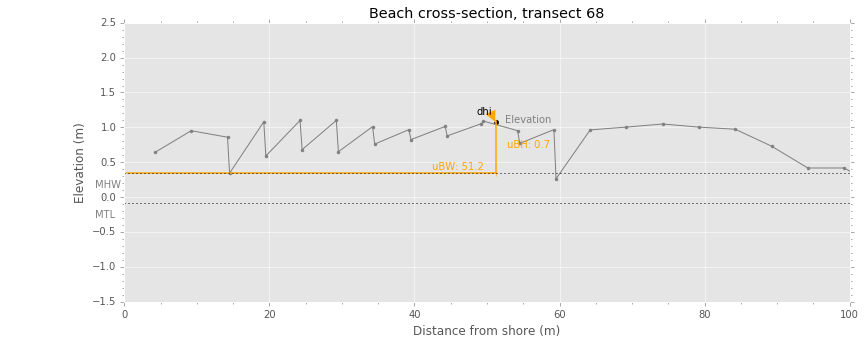

In [26]:
# Beach detail
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Beach cross-section, transect {}'.format(trans_in))

if not np.isnan(tran.DistDH):
    bend = tran.DistDH
    btop = tran.DH_z
elif not np.isnan(mz_dist):
    bend = mz_dist
    btop = maxz
else: 
    bend = 200
    btop = 4

# Plot line
ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, color='gray', linestyle='-', linewidth = 1, marker='.')
plt.annotate('Elevation', xy=(bend, btop), xytext=(bend+bend*0.025, btop), color='gray')

# Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='black')
plt.annotate('dlo', xy=(tran.DistDL, tran.DL_z), xytext=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.11),
            arrowprops=dict(facecolor='orange', shrink=0.005))
plt.scatter(tran.DistDH, tran.DH_z, color='black')
plt.annotate('dhi', xy=(tran.DistDH, tran.DH_z), xytext=(tran.DistDH-bend*0.05, tran.DH_z+btop*0.11),
            arrowprops=dict(facecolor='orange', shrink=0.005))
plt.scatter(tran.DistArm, tran.Arm_z, color='black')
plt.annotate('armor', xy=(tran.DistArm, tran.Arm_z), xytext=(tran.DistArm-20, tran.Arm_z+0.5),
            arrowprops=dict(facecolor='orange', shrink=0.005))

# Upper beach width and height
plt.plot([MHW, tran.uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.annotate('uBW: {:.1f}'.format(tran.uBW), xy=(5, MHW+0.06),
             xytext=(tran.uBW*0.83, MHW+0.05), color='orange')
plt.plot([tran.uBW, tran.uBW],[MHW, MHW + tran.uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
plt.annotate('uBH: {:.1f}'.format(tran.uBH), xy=(tran.uBW, (MHW + tran.uBH)),
             xytext=(tran.uBW+bend*0.03, MHW + tran.uBH*0.5), color='orange')

# ax.axis('scaled')
ax.set_xlim([-5, bend+bend*0.11])
ax.set_xlim([0, 100])
ax.minorticks_on()
ax.axhline(y=MTL, ls='dotted', color='black')
plt.annotate('MTL', xy=(0, MTL), xytext=(-4, MTL-0.2), color='gray')
ax.axhline(y=MHW, ls='dotted', color='black')
plt.annotate('MHW', xy=(0, MHW), xytext=(-4, MHW-0.2), color='gray')

plt.show()
plt.close('all')

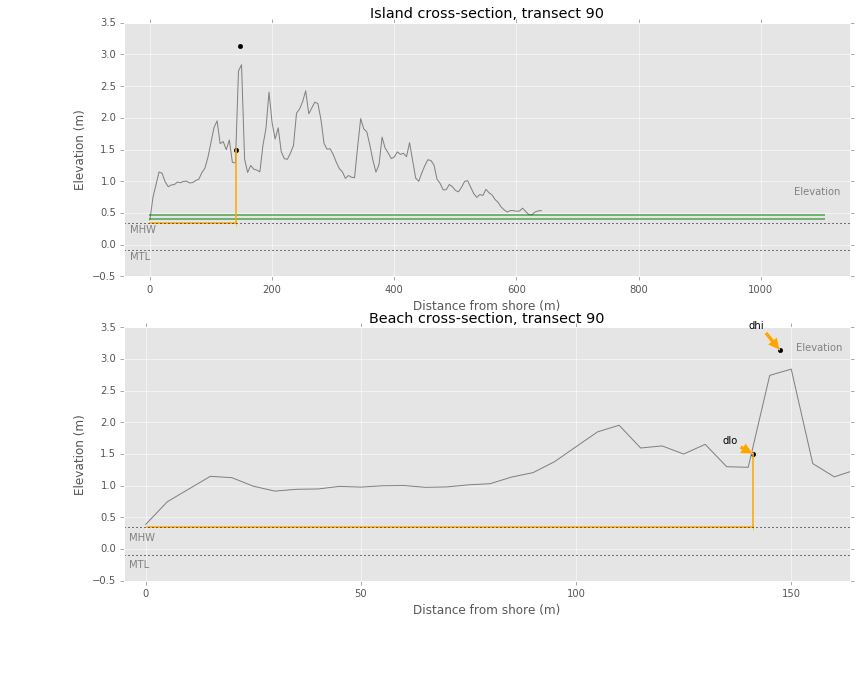

In [9]:
# Full cross-section
fig = plt.figure(figsize=(13,10)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(211)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Island cross-section, transect {}'.format(trans_in))

# Plot line
ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, color='gray', linestyle='-', linewidth = 1)
plt.annotate('Elevation', xy=(tran.WidthPart, float(pts_set['ptZmhw'].tail(1))), xytext=(tran.WidthPart-50, float(pts_set['ptZmhw'].tail(1))+0.6), color='gray')

# #Island widths
plt.plot([0, tran.WidthPart],[MHW+0.12, MHW+0.12], color='green', linestyle='-', linewidth = 2, alpha=0.5)
plt.plot([0, tran.WidthFull],[MHW+0.06, MHW+0.06], color='green', linestyle='-', linewidth = 2, alpha=0.5)

# #Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='black')
plt.scatter(tran.DistDH, tran.DH_z, color='black')
plt.scatter(tran.DistArm, tran.Arm_z, color='black')

# #Upper beach width and height
plt.plot([MHW, tran.uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.plot([tran.uBW, tran.uBW],[MHW, MHW + tran.uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')

# #ax.axis('scaled')
ax.set_xlim([-tran.WidthFull*0.038, tran.WidthFull + tran.WidthFull*0.038])
ax.axhline(y=MTL, ls='dotted', color='black')
plt.annotate('MTL', xy=(5, MTL), xytext=(-tran.WidthFull*0.03, MTL-0.15), color='gray')
ax.axhline(y=MHW, ls='dotted', color='black')
plt.annotate('MHW', xy=(5, MHW), xytext=(-tran.WidthFull*0.03, MHW-0.15), color='gray')

#====================
# Beach detail
# fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(212)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Beach cross-section, transect {}'.format(trans_in))

if tran.DistDH:
    bend = tran.DistDH
    btop = tran.DH_z
else:
    bend = mz_dist
    btop = maxz

# Plot line
ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, color='gray', linestyle='-', linewidth = 1)
plt.annotate('Elevation', xy=(bend, btop), xytext=(bend+bend*0.025, btop), color='gray')

# Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='black')
plt.annotate('dlo', xy=(tran.DistDL, tran.DL_z), xytext=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.11),
            arrowprops=dict(facecolor='orange', shrink=0.005))
plt.scatter(tran.DistDH, tran.DH_z, color='black')
plt.annotate('dhi', xy=(tran.DistDH, tran.DH_z), xytext=(tran.DistDH-bend*0.05, tran.DH_z+btop*0.11),
            arrowprops=dict(facecolor='orange', shrink=0.005))
plt.scatter(tran.DistArm, tran.Arm_z, color='black')
plt.annotate('armor', xy=(tran.DistArm, tran.Arm_z), xytext=(tran.DistArm-20, tran.Arm_z+0.5),
            arrowprops=dict(facecolor='orange', shrink=0.005))

# Upper beach width and height
plt.plot([MHW, tran.uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.plot([tran.uBW, tran.uBW],[MHW, MHW + tran.uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')

# ax.axis('scaled')
ax.set_xlim([-5, bend+bend*0.11])
ax.axhline(y=MTL, ls='dotted', color='black')
plt.annotate('MTL', xy=(0, MTL), xytext=(-4, MTL-0.2), color='gray')
ax.axhline(y=MHW, ls='dotted', color='black')
plt.annotate('MHW', xy=(0, MHW), xytext=(-4, MHW-0.2), color='gray')

plt.show()
plt.close('all')